# Combining and analyzing Halifax NHS and Census profiles from 2006-2016

This notebook analyzes data collected from the 2006-2016 National Household Survey profiles by census tract number.

In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pathlib
import matplotlib.pyplot as plt
import descartes
from shapely import wkt
import contextily as ctx
import operator
import mapclassify
import matplotlib.colors as cl

###Read Canadian census tract shapefile data
- Read data obtained from the [Statistics Canada 2016 Boundary files](https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm).
- Reduce dataset to selected tract ID (TID)s for the Halifax area, along with their geometry data.
- Read filtered data obtained from the 2006-2016 NHS profiles and combine it with the Halifax geometry data.

In [8]:
tracts = gpd.read_file('lct_000a16a_e.shp')
tracts = tracts.to_crs(epsg=3857)
tracts.head()

,CTUID,CTNAME,PRUID,PRNAME,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry
0,0010002.00,0002.00,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,001,10001,St. John's,B,"POLYGON ((-5868818.937 6032568.660, -5868626.4..."
1,5370001.09,0001.09,35,Ontario,537,35537,Hamilton,B,"POLYGON ((-8889513.236 5340616.750, -8889520.1..."
2,5370120.02,0120.02,35,Ontario,537,35537,Hamilton,B,"POLYGON ((-8899505.233 5337760.930, -8899589.5..."
3,0010006.00,0006.00,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,001,10001,St. John's,B,"POLYGON ((-5867749.009 6034404.476, -5867795.0..."
4,0010007.00,0007.00,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,001,10001,St. John's,B,"POLYGON ((-5866656.511 6035785.686, -5866595.6..."


In [9]:
data2006 = pd.read_csv('2006-census-data.csv')
data2011 = pd.read_csv('2011-census-data.csv')
data2016 = pd.read_csv('2016-census-data.csv')
data2006['geometry'] = None
data2011['geometry'] = None
data2016['geometry'] = None
data2006.head()

,tid,population,white,indigenous,black,asian,minority,adult,income,home,rent,education,p_white,p_indig,p_black,p_asian,p_mnrty,p_poc,p_educ,geometry
0,2050001.00,3650,3215,55,330,20,30,1915,19592,148100,475,260,0.880822,0.015068,0.090411,0.005479,0.008219,0.119178,0.071233,None
1,2050002.00,5200,4635,120,245,145,55,2805,24012,226552,534,835,0.891346,0.023077,0.047115,0.027885,0.010577,0.108654,0.160577,None
2,2050003.00,2700,2240,10,90,290,70,1740,26366,479064,907,990,0.829630,0.003704,0.033333,0.107407,0.025926,0.170370,0.366667,None
3,2050004.01,3205,2650,40,70,340,105,2425,17524,235254,780,1170,0.826833,0.012480,0.021841,0.106084,0.032761,0.173167,0.365055,None
4,2050004.02,4175,3415,50,115,510,85,2885,14430,378830,761,1295,0.817964,0.011976,0.027545,0.122156,0.020359,0.182036,0.310180,None


In [ ]:
for index, row in tracts.iterrows():
  t = float(row.CTUID)
  for j in range(len(data2006)):
    if t == float(data2006['tid'][j]):
      data2006['geometry'][j] = row.geometry
      data2011['geometry'][j] = row.geometry
      data2016['geometry'][j] = row.geometry

In [11]:
halifax2006 = gpd.GeoDataFrame(data2006, geometry='geometry')
halifax2011 = gpd.GeoDataFrame(data2011, geometry='geometry')
halifax2016 = gpd.GeoDataFrame(data2016, geometry='geometry')
halifax2016.head()

,tid,population,white,indigenous,black,asian,minority,adult,income,home,rent,education,p_white,p_indig,p_black,p_asian,p_mnrty,p_poc,p_educ,geometry
0,2050001.00,3820,3085,185,365,140,45,3060,30071,241737,647,425,0.807592,0.048429,0.095550,0.036649,0.011780,0.192408,0.111257,"POLYGON ((-7081505.483 5559791.027, -7081480.6..."
1,2050002.00,6045,5180,240,280,280,65,5055,31630,332449,701,1045,0.856907,0.039702,0.046319,0.046319,0.010753,0.143093,0.172870,"POLYGON ((-7080065.205 5563897.150, -7080020.1..."
2,2050003.00,2650,1930,25,55,590,50,2355,37808,885647,1197,995,0.728302,0.009434,0.020755,0.222642,0.018868,0.271698,0.375472,"POLYGON ((-7075139.274 5560833.900, -7075774.0..."
3,2050004.01,3515,2420,65,145,775,110,3355,24192,438599,1002,1170,0.688478,0.018492,0.041252,0.220484,0.031294,0.311522,0.332859,"POLYGON ((-7076788.719 5564428.644, -7076922.8..."
4,2050004.02,4645,3125,100,175,895,350,4420,20133,504598,1025,1580,0.672766,0.021529,0.037675,0.192680,0.075350,0.327234,0.340151,"POLYGON ((-7076903.990 5564534.164, -7076922.8..."


Text(0.5, 1.0, 'Halifax metro area 2016 populations by tract')

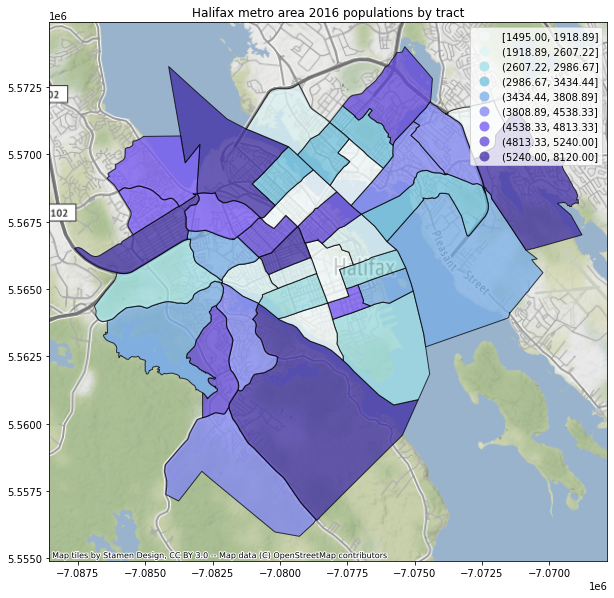

In [57]:
colours = ['#f4fbfc','#ddf3f5', '#9edfe5', '#70c2df', '#77ade6', '#7e84f3', '#7354f4', '#6146d9', '#3f2da5']
cmap = cl.ListedColormap(colours)
fig, ax = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
halifax2016.plot(     column='population',
                      ax=ax,
                      scheme='quantiles',
                      k=9,
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap)
ctx.add_basemap(ax, zoom=12)
ax.set_title("Halifax metro area 2016 populations by tract")

###Determine gentrification status from 2006 to 2016 tract data

Tracts are determined to have gentrified over a time period if they meet the following criteria:

1. An increase in a tract's educational attainment, as measured by the percentage of residents age 25 and over holding bachelor’s degrees, is in the top third percentile of all tracts within a metro area.
2. A tract’s median home value increases when adjusted for inflation.
3. The percentage increase in a tract’s inflation-adjusted median home value is in the top third percentile of all tracts within a metro area.

In [58]:
census_tracts = pd.DataFrame(columns=['tid','geometry','educ_eligible','home_value_increase','home_eligible', 'gentrified'])
census_tracts['tid'] = halifax2006['tid']
census_tracts['geometry'] = halifax2006['geometry']

In [ ]:
educ2006 = np.array(halifax2006['p_educ'])
educ2016 = np.array(halifax2016['p_educ'])

educ_difference = []
for i in range(len(educ2006)):
  educ_difference.append(educ2016[i] - educ2006[i])
educ_difference = np.array(educ_difference)

min_educ = educ_difference.min()
max_educ = educ_difference.max()
percentile66 = np.percentile(educ_difference, 66)

for i in range(len(census_tracts['tid'])):
  if educ_difference[i] > percentile66:
    census_tracts['educ_eligible'][i] = True
  else:
    census_tracts['educ_eligible'][i] = False

In [ ]:
inflation_rate = 1.1777
for i in range(len(halifax2006['tid'])):
  if (halifax2006['home'][i]*inflation_rate) < halifax2016['home'][i]:
    census_tracts['home_value_increase'][i] = True
  else:
    census_tracts['home_value_increase'][i] = False

In [ ]:
home2006 = np.array(halifax2006['home'])
home2016 = np.array(halifax2016['home'])

home_difference = []
for i in range(len(home2006)):
  home_difference.append(home2016[i] - (home2006[i]*inflation_rate))
home_difference = np.array(home_difference)
percentile66 = np.percentile(home_difference, 66)

for i in range(len(census_tracts['tid'])):
  if home_difference[i] > percentile66:
    census_tracts['home_eligible'][i] = True
  else:
    census_tracts['home_eligible'][i] = False

In [ ]:
for i in range(len(census_tracts['tid'])):
  if census_tracts['educ_eligible'][i] == True and census_tracts['home_value_increase'][i] == True and census_tracts['home_eligible'][i] == True:
    census_tracts['gentrified'][i] = True
  else:
    census_tracts['gentrified'][i] = False

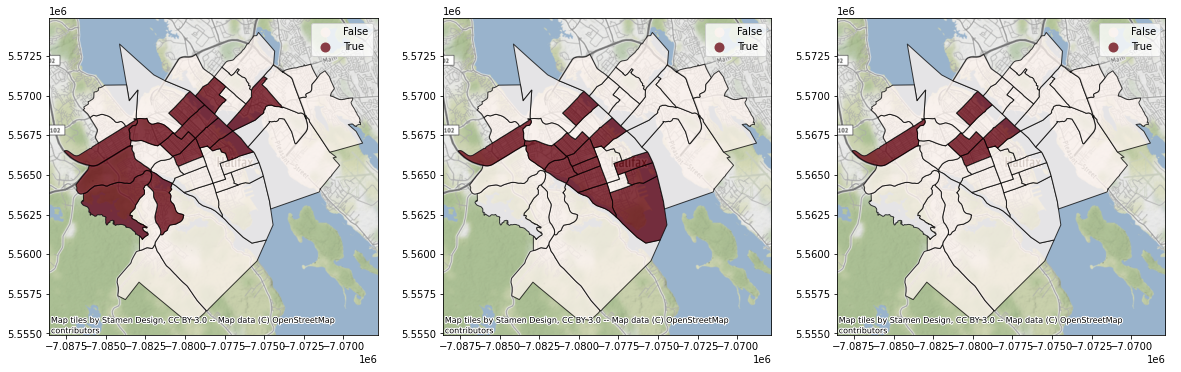

In [64]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
fig.set_figheight(20)
fig.set_figwidth(20)
trcts = gpd.GeoDataFrame(census_tracts, geometry='geometry')
trcts.plot(column='educ_eligible', ax=ax1, edgecolor='k', cmap='Reds',legend=True, alpha=0.75)
trcts.plot(column='home_eligible', ax=ax2, edgecolor='k', cmap='Reds', legend=True, alpha=0.75)
trcts.plot(column='gentrified', ax=ax3, edgecolor='k', cmap='Reds', legend=True, alpha=0.75)
ctx.add_basemap(ax1, zoom=12)
ctx.add_basemap(ax2, zoom=12)
ctx.add_basemap(ax3, zoom=12)

### Prepare graphs

In [ ]:
cmap1 = cl.ListedColormap(colours[0:9])
cmap2 = cl.ListedColormap(colours[0:7])
cmap3 = cl.ListedColormap(colours[0:6])
cmap4 = cl.ListedColormap(colours[0:5])

Text(0.5, 1.0, '2016')

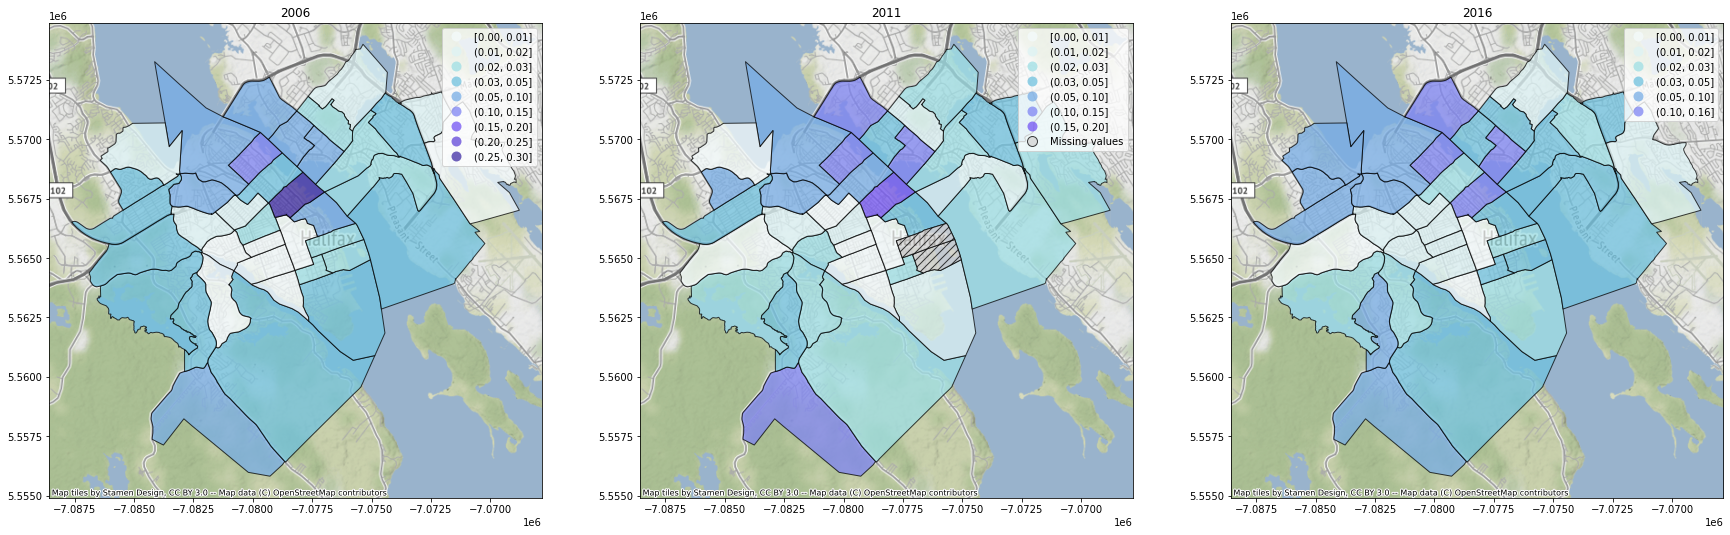

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='p_black',
                      ax=ax1,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05,0.1,0.15,0.2,0.25,0.3]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap1)
ctx.add_basemap(ax1, zoom=12)
ax1.set_title("2006")
halifax2011.plot(     column='p_black',
                      ax=ax2, 
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05,0.1,0.15,0.2]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap2)
ctx.add_basemap(ax2, zoom=12)
ax2.set_title("2011")
halifax2016.plot(     column='p_black',
                      ax=ax3, 
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05,0.1,0.16]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap3)
ctx.add_basemap(ax3, zoom=12)
ax3.set_title("2016")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='p_indig',
                      ax=ax1,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap4)
ctx.add_basemap(ax1, zoom=12)
ax1.set_title("2006")
halifax2011.plot(     column='p_indig',
                      ax=ax2, 
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05,0.10]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap3)
ctx.add_basemap(ax2, zoom=12)
ax2.set_title("2011")
halifax2016.plot(     column='p_indig',
                      ax=ax3, 
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.01,0.02,0.03,0.05,0.10]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap3)
ctx.add_basemap(ax3, zoom=12)
ax3.set_title("2016")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='p_asian',
                      ax=ax1,
                      scheme='quantiles',
                      classification_kwds=dict(bins=[0.01,0.02,0.05,0.10,0.15,0.20,0.25]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap3)
ctx.add_basemap(ax1, zoom=12)
ax1.set_title("2006")
halifax2011.plot(     column='p_asian',
                      ax=ax2,
                      scheme='quantiles',
                      #classification_kwds=dict(bins=[0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40]),
                      k=7,
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap2)
ctx.add_basemap(ax2, zoom=12)
ax2.set_title("2011")
halifax2016.plot(     column='p_asian',
                      ax=ax3,
                      scheme='quantiles',
                      #classification_kwds=dict(bins=[0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40]),
                      k=7,
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap2)
ctx.add_basemap(ax3, zoom=12)
ax3.set_title("2016")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
halifax2006.plot(     column='p_poc',
                      ax=ax1,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap1)
ctx.add_basemap(ax1, zoom=12)
ax1.set_title("2006")
halifax2011.plot(     column='p_poc',
                      ax=ax2,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      missing_kwds={ "color": "lightgrey", "hatch": "///", "label": "Missing values", },
                      cmap=cmap1)
ctx.add_basemap(ax2, zoom=12)
ax2.set_title("2011")
halifax2016.plot(     column='p_poc',
                      ax=ax3,
                      scheme='User_Defined',
                      classification_kwds=dict(bins=[0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40]),
                      alpha=0.75, 
                      edgecolor='k', 
                      legend=True,
                      cmap=cmap1)
ctx.add_basemap(ax3, zoom=12)
ax3.set_title("2016")